# Hidden Markov Modell (HMM) zum unehrlichen Casion

In dieser Rechnerübung wurde ein HMM, das ein Würfelspiel in einem unehrlichem Casino beschreibt, untersucht. Dabei wurde 
der Viterbi-Algorithmus implementiert, der den wahrscheinlichsten Pfad bei gegebener Sequenz x mittels dynamischen Programmieren berechnet:
$$\pi^* = argmax_\pi P(x,\pi)$$

Außerdem wurde noch der Forward-Backward-Algorithmus implementiert, dieser berechnet für jede Position i die Wahrscheinlichkeit des Zustandes k bei gegebener Sequenz x: 

$$P(\pi_i = k | x)$$

Die Algorithmen wurden an dem Textbuchbeispiel aus *Durbin et al. “Biological sequence analysis” Seite 54-57* getestet.

## Technische Probleme
Beim ersten Ansatz den Viterbi-Algorithmus zu implementieren, stellte die Implementierung des Backtrackings eine Schwierigleit da (siehe Anhang). Als erstes wurde eine Knoten-Klasse definiert, die immer auf den Vorgängerzustand zeigen sollte, dies wurde aber fehlerhaft implementiert. Im zweiten Anlauf wurde eine Backtrackingmatrix verwendet und damit wurde das Backtracking auch richtig implementiert.
Außerdem stellte die Transformierung der Wahrscheinlichkeiten in LogSpace bei dem Forward-Backward-Algorithmus ein Problem da, da dies nicht ganz so trivial ist, wie beim Viterbi-Algorithmus. 

## Implementierung des Viterbi-Algorithmus

Bei der Implementation des Viterbi-Algorithmus wurde die Wahrscheinlichkeit im LogSpace betrachtet, um eine numerisch stabile Implementation zu gewährleisten. Da bei der Multiplikation der Wahrscheinlichkeiten der Wert exponentiell schnell abfällt, kann dies schnell zu einem "Underflow"-Fehler führen. Im LogSpace müssen die einzelnen Werte nicht mehr multipliziert, sondern addiert werden:

$$ log(p_i * p_j) = log(p_i) + log (p_j)$$



## Implementierung des Forward-Backward-Algorithmus

Um die Unsicherheit des Modells an bestimmten Stellen zu untersuchen, eignet sich der Forward-Backward-Algorithmus,
da dieser für jede Position i die Wahrscheinlichkeit des Zustandes k bei gegebener Sequenz x berechnet. Der Viterbi-Algorithmus bestimmt global den besten Pfad, aber mit dem Forward-Backward-Algorithmus lassen sich lokale Bereiche etwas besser abschätzen. 

Auch hier ist es wichtig die Wahrscheinlichkeiten zu transformieren, um Underflow-Fehler zu vermeiden. Dies ist aber nicht ganz so trivial wie beim Viterbi-Algorithmus, da man hier mit Summen der Wahrscheinlichkeiten rechnet und nicht mehr nur mit dem Produkt. Auch hier wurde der Logarithmus verwendet:
    
$\widetilde{r} = log(p+q) $ mit $\widetilde{p} = log(p)$ and $\widetilde{q} = log(q)$ ergibt sich:

$$\widetilde{r} = log(exp(\widetilde{p})) +  log(exp(\widetilde{q}))$$

Indem $\widetilde{p}$ rausgezogen wird, wird folgender Term erhalten:

$$ \widetilde{r} = \widetilde{p} + log(1+ exp(\widetilde{q} - \widetilde{p}))$$

Wenn immer der größte Wert rausgezogen wird, lässt sich der Term effizienter berechnen.

Eine andere Möglichkeit für eine numerisch sinnvolle Implementation wäre die Skalierung der Wahrscheinlichkeitswerte, damit die Werte in einem numerischen handhabbaren Bereich bleiben. Da aber der log-Ansatz verwendet wurde, wird hier nicht näher auf die zweite Methode eingegangen.

## Anwendung auf Buchbeispiel

Der Viterbi-Algorithmus wurde auf die Würfelwurfsequenz aus Durbin angewandt. Der ausgegebene Pfad stimmt mit dem Buchbeispiel überein, dementsprechend müsste der Algorithmus hier richtig implementiert sein.

Die folgende Abbildung zeigt eine Visualisierung der Zustände des Pfades. Dabei wurde der Viterbi-Pfad und der reale Pfad aufgetragen. Zusätzlich wurde für jeden Wurf die Wahrscheinlichkeit visualisiert, dass ein Wurf fair ist.

<img src="Anwendung.png" width="750">

Was hier auffällig ist, ist, dass der Viterbi-Pfad zu großen Teilen mit dem realen Pfad übereinstimmt, aber an einigen Stellen natürlich den falschen Zustand angibt. Weiterhin fällt auf, dass der Graph der Wahrscheinlichkeiten ziemlich gut von dem wahren Pfad umrahmt wird und die Zustand teilweise sogar "genauer" als der Viterbi-Pfad vorraussagt.

Um dies weiter zu untersuchen wird aus der Posterior-Verteilung ein neuer Pfad definiert. Für den Posterior-Pfad gilt:

$$\widehat{\pi}_i = argmax_k P(\pi_i = k | x)$$

Betrachtet man die Sensitivität und Spezifität im Bezug auf die Erkennung von unfairen Würfeln, ergibt sich folgendes Ergebnis:

| Pfad   |      Sensitivität      |  Spezifität |
|----------|-------------:|------:|
| Viterbi |  0.7917 | 0.9607 |
| Posterior| 0.8333 | 0.9412 |

In diesem Beispiel hat also der Posterior-Pfad eine bessere Sensitivität als der Viterbi-Pfad, dafür aber eine geringere Spezifität.

# Quellcode

### Importieren der benötigten Module

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

## Erstellung des HMM
Die HMM besteht aus einem Alphabet, einer Menge von Zuständen, eine Transition-Matrix für die Übergangswahrscheinlichkeiten zwischen Zuständen und einer Emission-Matrix für die Emissionswahrscheinlichkeiten der Zeichen von bestimmten Zuständen.

In [2]:
alphabet = ['1','2','3','4','5','6']
states  = ['F','L']
transition = pd.DataFrame([[0.95,0.05],[0.1,0.90]],index=states, columns=states)
emission = pd.DataFrame([[1/6,1/6,1/6,1/6,1/6,1/6],[1/10,1/10,1/10,1/10,1/10,1/2]], index= states, columns= alphabet)
start_prob = {"F":0.5,"L":0.5}

In [3]:
print(transition)

      F     L
F  0.95  0.05
L  0.10  0.90


In [4]:
print(emission)

          1         2         3         4         5         6
F  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667
L  0.100000  0.100000  0.100000  0.100000  0.100000  0.500000


## Enlesen der Daten

In [5]:
def readFile(filename):
    """
    Reads a text file.
    """
    text = []
    with open(filename) as file:
        for line in file:
            if ((sline := line.replace("\t"," ").rstrip()) == ""): #if there is an empty line
                continue
            sline.replace("\t","halo")
            text.append(sline)
    return text

In [6]:
obs = "".join(readFile("Casino.txt"))

In [7]:
obs_cas = readFile("CasinoFull.txt") #einlesen der Versuchswerte, rolls, die, viterbi

In [8]:
#Zuordnung der eingelesenen werte als Strings, obs1 (rools), die (die), vit_durbin (viterbi)

obs1 = "" 
die = ""
vit_durbin = ""

for index, value in enumerate(obs_cas):
    i = index %3
    if i == 0:
        obs1 += re.split(r' +', value.strip())[1]
    elif i == 1:
        die += re.split(r' +', value.strip())[1]
    else: 
        vit_durbin += re.split(r' +', value.strip())[1]

## Implementierung der Algorithmen und Definitionen der nötigen Hilfsfunktionen

In [9]:
def logProb(init_p, trans_p, emit_p):
    """
    Nimmt ein init_p Dictionary und trans_p, emit_p Dataframe mit Wahrscheinlichkeiten entgegen und transformatiert diese in LogSpace.
    """
    
    init_p = init_p.copy()
    for key, value in init_p.items():
        init_p[key] = np.log(value)
    
    trans_p = trans_p.copy().apply(np.log)
    emit_p = emit_p.copy().apply(np.log)
    
    return init_p, trans_p, emit_p
        

In [10]:
def viterbi(obs, states, init_p, trans_p, emit_p):
    """
    Führt den Viterbi Algorithmus aus, bei beobachteter Sequenz obs und den Eigenschaften des HMM, states, init_p, trans_p und emit_p.
    Gibt einen Pfad zurück, mit maximaler Wahrscheinlichkeit pr(obs,Pfad) über alle Pfade des HMM. Außerdem wird noch die Matrix zur Berechnung der
    Wahrscheinlichkeiten und die Backtrackingmatrix zurückgegeben.
    """
    
    init_p, trans_p, emit_p = logProb(init_p, trans_p, emit_p) # umwandeln in Log-Wahrscheinlichkeiten
    
    T = len(obs) # Länge der beobachteten Sequenz
    K = len(states) # Anzähl der Zustände
    
    T1 = np.zeros((K,T)) #Matrix zur Speicherung der Wahrscheinlichkeiten
    T2 = np.zeros((K,T),dtype=int) #Backtracking matrix
    
    #Init Wahrscheinlichkeitsmatrix mit Startwahrscheinlichkeiten
    for k, state in enumerate(states):
        T1[k,0] = init_p[state] + emit_p.loc[state,obs[0]]
    
    #auffüllen der Wahrscheinlichkeits- und Backtrackingmatrix mit dynamischen Programmieren
    for i, o in enumerate(obs[1:],1):
        for k, state in enumerate(states):
            T1[k,i] = np.max([T1[l,i-1]+trans_p.loc[before,state]+emit_p.loc[state,o] for l,before in enumerate(states)])
            T2[k,i] = np.argmax([T1[l,i-1]+trans_p.loc[before,state]+emit_p.loc[state,o] for l,before in enumerate(states)])
    
    x = np.empty(T,dtype = str)
    z = np.argmax(T1[:, T - 1]) #index der größten Wahrscheinlichkeit in letzter Spalte er Matrix
    x[-1] = states[z] 
    
    for i in reversed(range(1, T)):
        z = T2[z,i] #backtracking des verwendeten Zustandes für i-1
        x[i-1] = states[z]
    
    return x,T1,T2

In [11]:
def forward_alg(obs, states, init_p, trans_p, emit_p):
    """
    Führt den forward-Algorithmus aus, um die Wahrscheinlichkeit zu bestimmen, dass eine Sequenz obs von einem HMM generiert wird.
    """
    
    
    T = len(obs) # Länge der beobachteten Sequenz
    K = len(states) # Anzähl der Zustände
    
    T1 = np.zeros((K,T)) #Matrix zur Speicherung der Forwardwahrscheinlichkeiten
    
    #Init Wahrscheinlichkeitsmatrix mit Startwahrscheinlichkeiten, vom Startzustand nur ein Pfad erlaubt.
    for k, state in enumerate(states):
        T1[k,0] = init_p[state] * emit_p.loc[state,obs[0]]
    
    #auffüllen der Wahrscheinlichkeits
    for i, o in enumerate(obs[1:],1):
        for k, state in enumerate(states):
            T1[k,i] = emit_p.loc[state, o] * np.sum([T1[l,i-1] * trans_p.loc[before, state] for l, before in enumerate(states)]) 
            
    p_obs = np.sum(T1[:,-1])
    
    return p_obs, T1
    

In [12]:
def backward_alg(obs,states, init_p, trans_p, emit_p):
    """
    Führt den backward-Algorithmus aus, um die Wahrscheinlichkeit zu bestimmen, dass eine Sequenz obs von einem HMM generiert wird.
    """
    T = len(obs) # Länge der beobachteten Sequenz
    K = len(states) # Anzähl der Zustände
    
    T = np.zeros((K,T)) #Matrix zur Speicherung der Backwardswahrscheinlichkeiten
    
    #Init Wahrscheinlichkeitsmatrix mit Startwahrscheinlichkeiten, vom Startzustand nur ein Pfad erlaubt.
    for k, state in enumerate(states):
        T[k,-1] = 1
    
    for i,o in reversed(list(enumerate(obs[:-1]))):
        for k, state in enumerate(states):
            T[k,i] = np.sum([trans_p.loc[state, after] * emit_p.loc[after, obs[i+1]] * T[l,i+1] for l, after in enumerate(states)] )
    
    p_obs = np.sum([init_p[state] * emit_p.loc[state, obs[0]] * T[l,0] for l,state in enumerate(states)])
    return p_obs,T

In [13]:
def forward_backward_alg(obs,states, init_p, trans_p, emit_p):
    """
    Führt den Forward-Backward-Algorithmus aus. Unter der Verwendung der bereits definierten Forward und Backward-Algorithmen.
    """
    T = len(obs) # Länge der beobachteten Sequenz
    K = len(states) # Anzähl der Zustände
    
    p_obs, F = forward_alg(obs,states, init_p, trans_p, emit_p)
    B = backward_alg(obs,states,init_p,trans_p,emit_p)[1]
    
    T = np.zeros((K,T))
    
    for i in range(len(obs)):
        for k in range(len(states)):
            T[k,i] = F[k,i]*B[k,i]/p_obs
    return T

In [14]:
def logsumexp(x):
    """
    Hilfsfunktion, um exp von Summen auch für sehr kleine Funktionen berechnen zu können.
    """
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x - c)))


In [15]:
def forward_alg_logspace(obs, states, init_p, trans_p, emit_p):
    """
    Führt den forward-Algorithmus in LogSpace aus, um die Wahrscheinlichkeit zu bestimmen, dass eine Sequenz obs von einem HMM generiert wird.
    """
    
    T = len(obs) # Länge der beobachteten Sequenz
    K = len(states) # Anzähl der Zustände
    
    T1 = np.zeros((K,T)) #Matrix zur Speicherung der Forwardwahrscheinlichkeiten
    
    init_p, trans_p, emit_p = logProb(init_p, trans_p, emit_p)
    
    
    #Init Wahrscheinlichkeitsmatrix mit Startwahrscheinlichkeiten, vom Startzustand nur ein Pfad erlaubt.
    for k, state in enumerate(states):
        T1[k,0] = init_p[state] + emit_p.loc[state,obs[0]]
    
    #auffüllen der Wahrscheinlichkeits
    for i, o in enumerate(obs[1:],1):
        for k, state in enumerate(states):
            T1[k,i] = emit_p.loc[state, o] + logsumexp([T1[l,i-1] + trans_p.loc[before, state] for l, before in enumerate(states)]) 
            
    p_obs = logsumexp(T1[:,-1])
    
    return p_obs, T1

In [16]:
def backward_alg_logspace(obs,states, init_p, trans_p, emit_p):
    
    """
    Führt den backward-Algorithmus in LogSpace aus, um die Wahrscheinlichkeit zu bestimmen, dass eine Sequenz obs von einem HMM generiert wird.
    """
    
    T = len(obs) # Länge der beobachteten Sequenz
    K = len(states) # Anzähl der Zustände
    
    T = np.zeros((K,T)) #Matrix zur Speicherung der Backwardswahrscheinlichkeiten
    
    init_p, trans_p, emit_p = logProb(init_p, trans_p, emit_p)
    
    
    #Init Wahrscheinlichkeitsmatrix mit Startwahrscheinlichkeiten, vom Startzustand nur ein Pfad erlaubt.
    for k, state in enumerate(states):
        T[k,-1] = 0
    
    for i,o in reversed(list(enumerate(obs[:-1]))):
        for k, state in enumerate(states):
            T[k,i] = logsumexp([trans_p.loc[state, after] + emit_p.loc[after, obs[i+1]] + T[l,i+1] for l, after in enumerate(states)] )
    
    p_obs = logsumexp([init_p[state] + emit_p.loc[state, obs[0]] + T[l,0] for l,state in enumerate(states)])
    return p_obs,T

In [17]:
def forward_backward_alg_logspace(obs,states, init_p, trans_p, emit_p):
    
    """
    Führt den Forward-Backward-Algorithmus in LogSpace aus. Unter der Verwendung der bereits definierten Forward und Backward-Algorithmen.
    """
    
    T = len(obs) # Länge der beobachteten Sequenz
    K = len(states) # Anzähl der Zustände
    
    log_p_obs, F = forward_alg_logspace(obs,states, init_p, trans_p, emit_p)
    B = backward_alg_logspace(obs,states,init_p,trans_p,emit_p)[1]
    
    T = np.zeros((K,T))
    
    for i in range(len(obs)):
        for k in range(len(states)):
            T[k,i] = F[k,i]+B[k,i] - log_p_obs
    return T

## Auswertung des Durbinbeispiels

### Graphische Auswertung

Im folgenden wird der Viterbi-Pfad mit dem echten Pfad und den Wahrscheinlichkeiten für einen Zustand graphisch visualisiert.

In [18]:
fb = forward_backward_alg_logspace(obs,states,start_prob,transition,emission)
vit = viterbi(obs,states,start_prob,transition,emission)

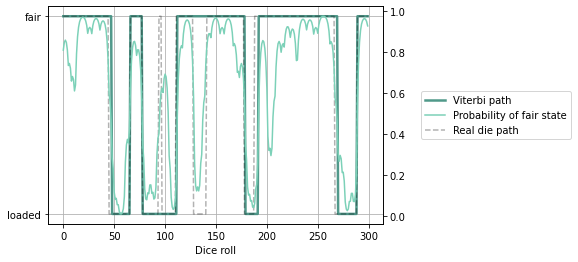

In [19]:
vit_path = [0 if x == 'L' else 1 for x in vit[0]]
post_path = np.exp(fb[0]) #umwandlung vom LogSpace zu normalen Wahrscheinlichkeiten
die_path = [0 if x == 'L' else 1 for x in die]

fig, ax = plt.subplots()

ax.set_yticks([0,1])
ax.set_yticklabels(["loaded","fair"])
ax.set_xlabel("Dice roll")
ax2 = ax.twinx()


lns1 = ax.plot(vit_path, label = "Viterbi path",linewidth=2.5,alpha = .9, color= "#3E8E7E")
lns2 = ax2.plot(post_path, color= "#7CD1B8", label = "Probability of fair state",alpha = 1)
lns3 = ax.plot(die_path, label = "Real die path",linewidth=1.5,alpha = 0.3, color= "black",linestyle='dashed')

lns = lns1+ lns2 + lns3
labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, loc=0)
ax.legend(lns, labs,loc='center left', bbox_to_anchor=(1.1, 0.5))


ax.grid()
plt.show()


### Vergleich der Wahrscheinlichkeiten
Hier werden die Wahrscheinlichkeiten des Viterbi, Posterior-Pfades und des echten Pfades selber betrachtet.
Dabei werden die Wahrscheinlichkeiten für den Pfad selbst und die Wahrscheinlichkeiten für die Emission gegeben den Pfad betrachtet.

In [20]:
def PosteriorPath(fb,states):
    """Berechnung des Pfades, in dem jeder Zustand an der Stelle i die höchste Wahrscheinlichkeit hat"""
    post_path = []
    for i in range(fb.shape[1]):
        arg_max = np.argmax(fb[:,i])
        post_path.append( states[arg_max])
    return post_path

In [21]:
post_path = PosteriorPath(fb,states)

In [22]:
def hiddenPathProb_logspace(path, init_p, trans_p, emit_p):
    
    """
    Berechnung der Wahrscheinlichkeit, dass ein HMM den angegebenen Pfad generiert.
    """
    
    res = 0
    
    init_p, trans_p = logProb(init_p, trans_p, emit_p)[0:2]
    
    for i, state in enumerate(path):
        if i == 0:
            res += init_p[state]
        else:
            res += trans_p.loc[path[i-1], state]
    return res
    

In [23]:
def outcomeProb_logspace(x,path, init_p, trans_p, emit_p):
    
    """
    Berechnung der Wahrscheinlichkeit einer Emissions-Sequenz für gegebenen Pfad.
    """
    
    res = 0        
    init_p, trans_p, emit_p = logProb(init_p, trans_p, emit_p)
    
    for i in range(len(x)):
        res +=  emit_p.loc[path[i],x[i]]
    return res    

Die folgenden Berechnungen zeigen, dass die Wahrscheinlichkeit für die Generierung des Viterbi-Pfades kleiner ist als die des Posterior-Pfades, aber zusammen mit den Emissionen, hat der Viterbi-Pfad (definitionsgemäß) dementsprechend die größte Wahrscheinlichkeit.

In [24]:
print("Wahrscheinlichkeiten (LogSpace) für Emission gegeben Posterior-Pfad und W. für Posterior-Pfad selbst\n",outcomeProb_logspace(obs, post_path, start_prob, transition, emission), hiddenPathProb_logspace(post_path, start_prob, transition, emission))

Wahrscheinlichkeiten (LogSpace) für Emission gegeben Posterior-Pfad und W. für Posterior-Pfad selbst
 -487.95752340884144 -56.99567145482143


In [25]:
print("Wahrscheinlichkeiten für Emission gegeben Viterbi-Pfad und W. für Viterbi-Pfad selbst\n",outcomeProb_logspace(obs, vit[0], start_prob, transition, emission), hiddenPathProb_logspace(vit[0], start_prob, transition, emission))

Wahrscheinlichkeiten für Emission gegeben Viterbi-Pfad und W. für Viterbi-Pfad selbst
 -498.3558596306204 -41.13814301515145


In [26]:
print("Wahrscheinlichkeiten für Emission gegeben der echte Pfad und W. für echten Pfad selbst\n",outcomeProb_logspace(obs, die, start_prob, transition, emission), hiddenPathProb_logspace(die, start_prob, transition, emission))

Wahrscheinlichkeiten für Emission gegeben der echte Pfad und W. für echten Pfad selbst
 -498.04801546607587 -52.07027678339977


Der berechnete Pfad stimmt auch mit dem Buchbeispiel überein, dementsprechend scheint der Algorithmus richtig implementiert zu sein.

In [27]:
print("Berechneter Viterbi-Pfad stimmt mit Buch-Beispiel überein: ","".join(vit[0]) == vit_durbin)

Berechneter Viterbi-Pfad stimmt mit Buch-Beispiel überein:  True


### Sensitivität und Spezifität
In diesem Abschnitt wird die Sensitivität und Spezifität des Viterbi- und des Posterior-Pfades im Bezug auf die Erkennung von unfairen Würfeln betrachtet.

In [28]:
def tpr_tnr(estimation, real, char):
    """
    Berechnet tpr (Sensitivität) und tnr (Spezifität) für gegebenen Pfad und realem Pfad im Bezug auf übergebenem Zustand (char).
    """
    
    res = {"tp":0,"tn":0,"fp":0,'fn':0}
    for i in range(len(estimation)):
        if (x := estimation[i]) == real[i]:
            if x == char:
                res["tp"] += 1
            else:
                res["tn"] += 1
        elif (x := estimation[i]) != real[i]:
            if x == char:
                res["fp"] +=1
            else:
                res["fn"] +=1
    tpr = 0 if res["tp"] == 0 else res["tp"]/(res["tp"]+res["fn"])
    tnr = 0 if res["tn"] == 0 else res["tn"]/(res["tn"]+res["fp"])
    
    return tpr, tnr

In [29]:
print("Viterbi-Pfad: (tpr, tnr)")
print(tpr_tnr(vit[0],die,"L"))

Viterbi-Pfad: (tpr, tnr)
(0.7916666666666666, 0.9607843137254902)


In [30]:
print("Posterior-Pfad: (tpr, tnr)")
print(tpr_tnr(post_path,die,"L"))

Posterior-Pfad: (tpr, tnr)
(0.8333333333333334, 0.9411764705882353)


# Anhang

## Erster Ansatz für Viterbi
Hier befindet sich der ursprüngliche Ansatz, bei dem das Backtracking nicht richtig implementiert war. Dabei wurde zum Backtracking ein Knoten-Objekt erstellt, welches jeweils immer den Vorgängerknoten enthalten sollte.

In [31]:

"""
Dieser Ansatz funktionierte nicht, da das Backtracking nicht richtig implementiert ist. 
"""
"""
class BacktrackingNode:
    def __init__(self, state= "", predecessor = None):
        self.state = state
        self.predecessor = predecessor
    def __repr__(self):
        return f'{self.state}{self.predecessor}' if self.predecessor != None else f'{self.state}'

seq = "11" #test

def viterbi(seq):
    n = len(seq)
    viterbi_matrix = np.zeros((len(states),n))

    #initialisation:

    s_source = 1
    backtracking = []
    
    init_prob = [0.6,0.4]

    #calculating the viterbi matrix
    for i, char in enumerate(seq):
        for j, state in enumerate(states):
            if i == 0:
                viterbi_matrix[j,i] = np.log(s_source* init_prob[j] * emission.loc[state, char])
                backtracking.append(BacktrackingNode(state))
            else:
                transition_score = max([(viterbi_matrix[l,i-1] + np.log(transition.loc[before,state]),before) for l, before in enumerate(states)], key = lambda item: item[0])
                viterbi_matrix[j,i] = np.log(emission.loc[state,char]) + transition_score[0]
                backtracking[j] = BacktrackingNode(transition_score[1],backtracking[j]) 


    log_prob = max(viterbi_matrix[:,-1])
    backtracking = backtracking[np.argmax(viterbi_matrix[:,-1])]
    
    return log_prob, backtracking
"""
print("")

## Münzwurfmodell
Zum Testen der Funktionen und Überlegungen wurde zunächst ein etwas leichteres Modell betrachtet. Hier wird kein Würfel geworfen, sondern eine Münze. Dabei tauscht der Casinobesitzer zwischen der fairen (fair -> "F") und der gezinkten Münze (biased -> "b"). Die möglichen Emissionen sind dementsprechend Kopf ("Head" -> "H") und Zahl ("Tail" -> "T"). 

In [32]:
obs_t = "HHHHHHHHHHHHHHHTHTHTHTHTHTHTHTHTHTHTHTHT"

alphabet_t = ['H','T']
states_t  = ['F','B']
transition_t = pd.DataFrame([[0.9,0.1],[0.1,0.9]],index=states_t, columns=states_t)
emission_t = pd.DataFrame([[0.5,0.5],[3/4,1/4]], index= states_t, columns= alphabet_t)
start_prob_t = {"F":0.5,"B":0.5}

In [33]:
vit_test = viterbi(obs_t,states_t,start_prob_t,transition_t,emission_t)[0]
fb_test = forward_backward_alg(obs_t,states_t,start_prob_t,transition_t,emission_t)[0]

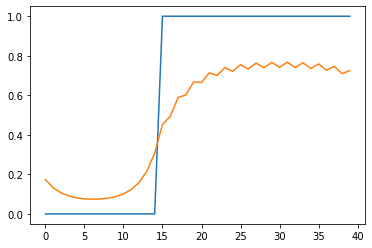

In [34]:
plt.plot([(lambda x: 1 if x == "F" else 0)(x) for x in vit_test])
plt.plot(fb_test)